# Miami Housing · Projeto de Análise e Modelagem

## Objetivo
Investigar os determinantes do preço de venda de imóveis residenciais em Miami (2016), estruturando um fluxo incremental que contempla: (i) descoberta e inspeção do conjunto de dados; (ii) limpeza e padronização (*tidy*); (iii) análise exploratória com gramática de gráficos; e (iv) preparação de artefatos para etapas posteriores de modelagem preditiva e inferencial.

## Equipe
- João Pedro Queiroz Viana  
- João Gabriel Faus Faraco


## Importações e configurações

In [34]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

DATA_DIR = Path("data")
print(DATA_DIR)

data


## Obtendo os dados

In [35]:
import pandas as pd


def load_housing_data(data_dir: Path) -> pd.DataFrame:
    '''Loads the Miami Housing dataset.

    Loads the Miami Housing dataset from the specified directory.

    Args:
        data_dir: The directory from which the dataset will be loaded.

    Returns:
        A pandas DataFrame containing the California Housing Prices dataset.
    '''
    csv_path = data_dir / 'miami-housing.csv'
    df = pd.read_csv(csv_path)
    return df

In [36]:
data = load_housing_data(DATA_DIR)

print(f'O dataset tem {data.shape[0]} linhas e {data.shape[1]} colunas.')
print('As colunas são:')
for column_name in data.columns:
    print(f'- "{column_name}"')

O dataset tem 13932 linhas e 17 colunas.
As colunas são:
- "LATITUDE"
- "LONGITUDE"
- "PARCELNO"
- "SALE_PRC"
- "LND_SQFOOT"
- "TOT_LVG_AREA"
- "SPEC_FEAT_VAL"
- "RAIL_DIST"
- "OCEAN_DIST"
- "WATER_DIST"
- "CNTR_DIST"
- "SUBCNTR_DI"
- "HWY_DIST"
- "age"
- "avno60plus"
- "month_sold"
- "structure_quality"


## Entendimento do Negócio

### O que os dados representam

Este dataset (arquivo `miami-housing.csv`, 13.932 linhas × 17 colunas) contém **registros de transações imobiliárias residenciais** na região de Miami (EUA), com:
- **Preço de venda** do imóvel,
- **Características físicas** do lote e da área construída,
- **Localização geográfica** (latitude/longitude),
- **Qualidade estrutural** do imóvel,
- **Proximidades e acessibilidade** (distâncias até mar/água, ferrovia, rodovias e centros urbanos),
- **Atributos contextuais** (ex.: mês da venda; indicador binário relacionado a ruído/ambiente — ver nota abaixo).

> **Objetivo típico de negócio:** apoiar análises de **precificação**, avaliação de **fatores que influenciam valor** (amenidades e acessibilidade), **segmentação** de portfólio e **modelagem preditiva** do preço de venda.

> **Observação importante:** a coluna `avno60plus` é um indicador binário (0/1). Pelo padrão de datasets imobiliários, é **provavelmente** um marcador de **exposição a ruído acima de 60 dB** (ex.: ruído aeronáutico “60+ dB”). Recomenda-se **confirmar no dicionário de dados oficial** do projeto.

---

### Descrição das Colunas

| Coluna              | Tipo      | Tipo de Variável (Natureza) | Descrição de Negócio                                                                  | Unidade / Domínio                        | Exemplos / Faixa (min–max)              |
| ------------------- | --------- | --------------------------- | ------------------------------------------------------------------------------------- | ---------------------------------------- | --------------------------------------- |
| `LATITUDE`          | float     | Contínua                    | Latitude geográfica do imóvel (para georreferenciamento e mapas).                     | Graus decimais                           | 25.4343 – 25.9744                       |
| `LONGITUDE`         | float     | Contínua                    | Longitude geográfica do imóvel.                                                       | Graus decimais                           | −80.5422 – −80.1198                     |
| `PARCELNO`          | int       | Categórica (ID)             | Identificador cadastral do lote/parcela (parcel number).                              | ID numérico                              | ~1.02e11 – 3.66e12                      |
| `SALE_PRC`          | float     | Contínua                    | **Preço de venda** do imóvel (variável-alvo comum em modelos).                        | USD                                      | **72.000 – 2.650.000**                  |
| `LND_SQFOOT`        | int       | Contínua                    | **Área do terreno (lote)**.                                                           | Pés quadrados                            | 1.248 – 57.064                          |
| `TOT_LVG_AREA`      | int       | Contínua                    | **Área construída habitável** (living area).                                          | Pés quadrados                            | 854 – 6.287                             |
| `SPEC_FEAT_VAL`     | int       | Contínua                    | Valor agregado por **características especiais** (ex.: piscina, lareira, deck).       | USD (valor estimado de amenidades)       | 0 – 175.020                             |
| `RAIL_DIST`         | float     | Contínua                    | Distância à **ferrovia** (proxy de acessibilidade/ruído).                             | Metros (aprox.)                          | 10,5 – 29.621,5                         |
| `OCEAN_DIST`        | float     | Contínua                    | Distância ao **oceano** (amenidade costeira).                                         | Metros (aprox.)                          | 236,1 – 75.744,9                        |
| `WATER_DIST`        | float     | Contínua                    | Distância ao **corpo d’água** mais próximo (lagos/canais, exceto oceano).             | Metros (aprox.)                          | 0 – 50.399,8                            |
| `CNTR_DIST`         | float     | Contínua                    | Distância ao **CBD** (centro principal da cidade).                                    | Metros (aprox.)                          | 3.825,6 – 159.976,5                     |
| `SUBCNTR_DI`        | float     | Contínua                    | Distância ao **subcentro** urbano mais próximo.                                       | Metros (aprox.)                          | 1.462,8 – 110.553,8                     |
| `HWY_DIST`          | float     | Contínua                    | Distância à **rodovia** mais próxima.                                                 | Metros (aprox.)                          | 90,2 – 48.167,3                         |
| `age`               | int       | Contínua                    | **Idade do imóvel** na data da venda.                                                 | Anos                                     | 0 – 96                                  |
| `avno60plus`        | int (0/1) | Categórica (Binária)        | **Indicador binário** relacionado ao ambiente; **provável** exposição a ruído ≥60 dB. | 0 = não exposto; 1 = exposto (confirmar) | 0 ou 1 (média ~0,015)                   |
| `month_sold`        | int       | Categórica (Ordinal)        | **Mês da venda** (sazonalidade de mercado).                                           | 1–12                                     | 1 – 12 (distribuição em todos os meses) |
| `structure_quality` | int       | Categórica (Ordinal)        | **Qualidade construtiva** em escala ordinal.                                          | Escala 1–5 (1=baixa, 5=alta)             | 1–5 (moda ~4)                           |

### Leituras rápidas de negócio

- **Preço de venda (`SALE_PRC`)** tende a ser explicado por: área construída, área do lote, qualidade, idade, amenidades (`SPEC_FEAT_VAL`) e **localização** (distâncias a mar/água/centros/rodovias).
- **Localização importa**: menor `OCEAN_DIST` e `WATER_DIST` (maior proximidade à água) geralmente aumentam valor; já menor `RAIL_DIST`/`HWY_DIST` pode ter efeitos ambíguos (acessibilidade vs. ruído).
- **Sazonalidade**: `month_sold` ajuda a capturar ciclos de demanda/oferta no ano.
- **Qualidade e idade**: `structure_quality` e `age` capturam condição do imóvel; imóveis mais novos e com melhor padrão costumam precificar acima da média.

## Relações a serem observadas

### Características físicas e estruturais:
1. Esta etapa busca investigar quais atributos dos imóveis explicam a variação nos preços de venda `SALE_PRC`. Serão analisadas variáveis como área construída `TOT_LVG_AREA`, área do lote `LND_SQFOOT`, qualidade estrutural `structure_quality` e idade `age`. O objetivo é verificar se há correlação positiva entre tamanho e preço, identificar possíveis retornos decrescentes em terrenos muito amplos, avaliar se maiores níveis de qualidade estão associados a valores mais altos e investigar se imóveis mais antigos tendem a apresentar menor valorização.

### Fatores geográficos e localização:
2. Nesta análise, o foco está em avaliar o impacto da localização sobre o valor dos imóveis, compreendendo como fatores geográficos influenciam o preço de venda `SALE_PRC`. Serão examinadas as distâncias em relação a pontos de interesse e fontes de ruído, como a proximidade ao oceano `OCEAN_DIST` e a corpos d’água `WATER_DIST`, que podem indicar valorização de áreas costeiras. Também será investigado o efeito de centralidade, observando se imóveis mais próximos ao centro urbano `CNTR_DIST` e a subcentros `SUBCNTR_DI` apresentam preços mais elevados. Além disso, será analisada a influência da distância a rodovias `HWY_DIST`, que pode ter efeitos ambíguos — associando-se tanto à acessibilidade quanto ao ruído e à poluição. Por fim, pretende-se explorar se a proximidade à ferrovia `RAIL_DIST` e a exposição a ruído (avno60plus) impactam negativamente a atratividade e o valor dos imóveis.

### Aspectos contextuais e sazonais:
3. O objetivo desta etapa é analisar padrões sazonais e fatores contextuais que influenciam o preço de venda `SALE_PRC`. Serão avaliados o mês da venda `month_sold`, para identificar possíveis variações sazonais, e o valor das amenidades `SPEC_FEAT_VAL`, como piscinas ou lareiras, que podem agregar valor ao imóvel. Além disso, será considerada a variável `avno60plus`, que indica exposição a ruído, a fim de verificar se ambientes mais ruidosos tendem a apresentar menor valorização.

## Análise exploratória

### Análise global

#### Inspeção inicial dos dados

Iniciamos a análise exploratória observando as **primeiras linhas do dataset**, com o objetivo de verificar:
- a estrutura tabular básica;
- a formatação e padronização dos valores;
- a presença de colunas numéricas e categóricas.

Essa inspeção inicial auxilia na familiarização com o conjunto de dados e na detecção precoce de eventuais inconsistências de leitura ou codificação.

In [37]:
data.head()

,LATITUDE,LONGITUDE,PARCELNO,SALE_PRC,LND_SQFOOT,TOT_LVG_AREA,SPEC_FEAT_VAL,RAIL_DIST,OCEAN_DIST,WATER_DIST,CNTR_DIST,SUBCNTR_DI,HWY_DIST,age,avno60plus,month_sold,structure_quality
0,25.891031,-80.160561,622280070620,440000.0,9375,1753,0,2815.9,12811.4,347.6,42815.3,37742.2,15954.9,67,0,8,4
1,25.891324,-80.153968,622280100460,349000.0,9375,1715,0,4359.1,10648.4,337.8,43504.9,37340.5,18125.0,63,0,9,4
2,25.891334,-80.153740,622280100470,800000.0,9375,2276,49206,4412.9,10574.1,297.1,43530.4,37328.7,18200.5,61,0,2,4
3,25.891765,-80.152657,622280100530,988000.0,12450,2058,10033,4585.0,10156.5,0.0,43797.5,37423.2,18514.4,63,0,9,4
4,25.891825,-80.154639,622280100200,755000.0,12800,1684,16681,4063.4,10836.8,326.6,43599.7,37550.8,17903.4,42,0,7,4


#### Estrutura e tipos de dados

Em seguida, examinamos a **estrutura completa do DataFrame**, incluindo o tipo de dado identificado automaticamente pelo *pandas*, a contagem de valores não nulos e o uso de memória.

Essa etapa confirma:
- a **ausência de valores ausentes**, indicando completude do dataset;
- o **tipo de dado** apropriado para cada variável (`int64` ou `float64`);
- a **proporção equilibrada** entre variáveis contínuas (ex.: área, distância) e discretas (ex.: mês da venda, qualidade estrutural).

Essas informações são essenciais para orientar o tratamento posterior e a escolha de técnicas analíticas adequadas.

In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13932 entries, 0 to 13931
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   LATITUDE           13932 non-null  float64
 1   LONGITUDE          13932 non-null  float64
 2   PARCELNO           13932 non-null  int64  
 3   SALE_PRC           13932 non-null  float64
 4   LND_SQFOOT         13932 non-null  int64  
 5   TOT_LVG_AREA       13932 non-null  int64  
 6   SPEC_FEAT_VAL      13932 non-null  int64  
 7   RAIL_DIST          13932 non-null  float64
 8   OCEAN_DIST         13932 non-null  float64
 9   WATER_DIST         13932 non-null  float64
 10  CNTR_DIST          13932 non-null  float64
 11  SUBCNTR_DI         13932 non-null  float64
 12  HWY_DIST           13932 non-null  float64
 13  age                13932 non-null  int64  
 14  avno60plus         13932 non-null  int64  
 15  month_sold         13932 non-null  int64  
 16  structure_quality  139

#### Verificação de duplicidades

Aqui verificamos se o dataset contém **linhas duplicadas**, que poderiam enviesar a análise estatística ou gerar redundância informacional.

A remoção é feita com o método `drop_duplicates()`, seguido de nova inspeção com `.info()` para comparar o número de registros e colunas com o dataset original.

O resultado mostra que o conjunto de dados **não possuía duplicatas**, mantendo o mesmo total de 13.932 linhas e 17 colunas.


In [39]:
data_no_dups = data.drop_duplicates()

In [40]:
data_no_dups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13932 entries, 0 to 13931
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   LATITUDE           13932 non-null  float64
 1   LONGITUDE          13932 non-null  float64
 2   PARCELNO           13932 non-null  int64  
 3   SALE_PRC           13932 non-null  float64
 4   LND_SQFOOT         13932 non-null  int64  
 5   TOT_LVG_AREA       13932 non-null  int64  
 6   SPEC_FEAT_VAL      13932 non-null  int64  
 7   RAIL_DIST          13932 non-null  float64
 8   OCEAN_DIST         13932 non-null  float64
 9   WATER_DIST         13932 non-null  float64
 10  CNTR_DIST          13932 non-null  float64
 11  SUBCNTR_DI         13932 non-null  float64
 12  HWY_DIST           13932 non-null  float64
 13  age                13932 non-null  int64  
 14  avno60plus         13932 non-null  int64  
 15  month_sold         13932 non-null  int64  
 16  structure_quality  139

#### Tabela de inspeção das colunas

A tabela abaixo apresenta um **resumo estrutural do dataset**, descrevendo os **tipos de dados** e a **integridade** de cada variável:

| Métrica | Descrição |
|----------|------------|
| **coluna** | Nome da variável presente no conjunto de dados. |
| **tipo** | Tipo de dado em cada coluna (`int64`, `float64`, etc.). |
| **valores_nulos** | Quantidade de registros ausentes. Neste caso, o dataset não apresenta valores nulos. |
| **valores_não_nulos** | Quantidade de registros válidos (não nulos). |
| **valores_únicos** | Número de valores distintos observados na coluna. |

Observações iniciais:
- O dataset está **completo**, sem **valores ausentes** em nenhuma variável.  
- As colunas `avno60plus`, `month_sold` e `structure_quality` possuem baixa cardinalidade, sugerindo **variáveis categóricas ou discretas**.  
- As demais colunas apresentam alta variação e podem ser tratadas como **variáveis contínuas** — adequadas para análises estatísticas e modelagem preditiva.  
- A quantidade de valores únicos elevada em variáveis como `LATITUDE`, `LONGITUDE`, `RAIL_DIST`, `OCEAN_DIST` e `CNTR_DIST` confirma o caráter **espacial e contínuo** dessas medições.

Este diagnóstico confirma a **consistência e completude** do conjunto de dados, servindo como base para a análise exploratória subsequente.


In [41]:
summary = pd.DataFrame({
    "coluna": data.columns,
    "tipo": [str(t) for t in data.dtypes.values],
    "valores_nulos": data.isna().sum().values,
    "valores_nao_nulos": data.notna().sum().values,
    "valores_unicos": data.nunique(dropna=True).values
})


summary


,coluna,tipo,valores_nulos,valores_nao_nulos,valores_unicos
0,LATITUDE,float64,0,13932,13776
1,LONGITUDE,float64,0,13932,13776
2,PARCELNO,int64,0,13932,13776
3,SALE_PRC,float64,0,13932,2111
4,LND_SQFOOT,int64,0,13932,4696
5,TOT_LVG_AREA,int64,0,13932,2978
6,SPEC_FEAT_VAL,int64,0,13932,7583
7,RAIL_DIST,float64,0,13932,13235
8,OCEAN_DIST,float64,0,13932,13617
9,WATER_DIST,float64,0,13932,13218


#### Conclusão da análise global

A inspeção inicial confirma que o dataset:
- Está **completo** (sem valores nulos);
- Não possui **linhas duplicadas**;
- Contém **apenas variáveis numéricas** (contínuas e discretas), o que facilita o processamento estatístico e a modelagem;
- Apresenta estrutura **limpa e padronizada**, pronta para análises descritivas e inferenciais.

Com isso, podemos avançar para a etapa de **análise preliminar das features**, aprofundando a compreensão individual das variáveis e suas relações com o preço de venda (`SALE_PRC`).


### Análise preliminar das features

#### Seleção de variáveis numéricas

Nesta etapa, separam-se as **features numéricas contínuas** das variáveis categóricas ou discretas.

O objetivo é garantir que as análises estatísticas subsequentes — especialmente as medidas de dispersão e variabilidade — sejam aplicadas apenas às variáveis apropriadas.

As colunas `month_sold`, `structure_quality`, `avno60plus` e `PARCELNO` foram excluídas por representarem **categorias, identificadores ou variáveis discretas**, que não são adequadas para o cálculo de métricas contínuas.

In [42]:
categorical_features = ['month_sold', 'structure_quality', 'avno60plus', 'PARCELNO']

numeric_data = data.select_dtypes(include='number').drop(columns=categorical_features, errors='ignore')

#### Estatísticas descritivas das variáveis numéricas

A tabela a seguir apresenta o **resumo estatístico** das variáveis numéricas contínuas do dataset.  
Os indicadores incluem:

- **count**: número de observações válidas  
- **mean / std**: média e desvio-padrão (dispersão absoluta)  
- **min / max**: limites inferior e superior observados  
- **quartis (25%, 50%, 75%)**: valores de referência que ajudam a identificar assimetrias e potenciais outliers

Essa visão fornece um panorama da **escala e amplitude** de cada variável, servindo como base para o cálculo de medidas de dispersão relativa, como o **Coeficiente de Variação (CV)**.

In [43]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
LATITUDE,13932.0,2.572881e+01,1.406333e-01,2.543433e+01,2.562006e+01,2.573181e+01,2.585227e+01,2.597438e+01
LONGITUDE,13932.0,-8.032748e+01,8.919907e-02,-8.054217e+01,-8.040328e+01,-8.033891e+01,-8.025802e+01,-8.011975e+01
PARCELNO,13932.0,2.356496e+12,1.199290e+12,1.020008e+11,1.079160e+12,3.040300e+12,3.060170e+12,3.660170e+12
SALE_PRC,13932.0,3.999419e+05,3.172147e+05,7.200000e+04,2.350000e+05,3.100000e+05,4.280000e+05,2.650000e+06
LND_SQFOOT,13932.0,8.620880e+03,6.070089e+03,1.248000e+03,5.400000e+03,7.500000e+03,9.126250e+03,5.706400e+04
TOT_LVG_AREA,13932.0,2.058045e+03,8.135385e+02,8.540000e+02,1.470000e+03,1.877500e+03,2.471000e+03,6.287000e+03
SPEC_FEAT_VAL,13932.0,9.562493e+03,1.389097e+04,0.000000e+00,8.100000e+02,2.765500e+03,1.235225e+04,1.750200e+05
RAIL_DIST,13932.0,8.348549e+03,6.178027e+03,1.050000e+01,3.299450e+03,7.106300e+03,1.210260e+04,2.962150e+04
OCEAN_DIST,13932.0,3.169099e+04,1.759508e+04,2.361000e+02,1.807935e+04,2.854175e+04,4.431065e+04,7.574490e+04
WATER_DIST,13932.0,1.196029e+04,1.193299e+04,0.000000e+00,2.675850e+03,6.922600e+03,1.920000e+04,5.039980e+04


#### Coeficiente de Variação (CV)

O **Coeficiente de Variação** é uma métrica que expressa o desvio-padrão em relação à média — uma forma **relativa e adimensional de dispersão**.

Ele permite comparar a variabilidade de variáveis com **escalas diferentes**, sendo calculado pela razão:

\[
CV = \frac{\text{Desvio Padrão}}{\text{Média}}
\]

Valores altos de CV indicam **maior heterogeneidade** dos dados, enquanto valores baixos sugerem **maior estabilidade** em torno da média.


In [44]:
def compute_coefficient_of_variation(data: pd.DataFrame) -> pd.Series:
    """
    Computes the Coefficient of Variation (CV) for each numerical column 
    in a DataFrame, excluding categorical or discrete features.

    Args:
        data: A pandas DataFrame.

    Returns:
        A pandas Series containing the Coefficient of Variation for each
        selected column.
    """
    categorical_features = ['month_sold', 'structure_quality', 'avno60plus', 'PARCELNO']
    
    numeric_cols = [
        col for col in data.select_dtypes(include='number').columns
        if col not in categorical_features
    ]
    
    stats = data[numeric_cols].describe().transpose()
    
    cv = stats['std'] / stats['mean']
    cv.rename('Coefficient of Variation', inplace=True)
    
    return cv

print(compute_coefficient_of_variation(data).round(2).to_markdown())

|               |   Coefficient of Variation |
|:--------------|---------------------------:|
| LATITUDE      |                       0.01 |
| LONGITUDE     |                      -0    |
| SALE_PRC      |                       0.79 |
| LND_SQFOOT    |                       0.7  |
| TOT_LVG_AREA  |                       0.4  |
| SPEC_FEAT_VAL |                       1.45 |
| RAIL_DIST     |                       0.74 |
| OCEAN_DIST    |                       0.56 |
| WATER_DIST    |                       1    |
| CNTR_DIST     |                       0.47 |
| SUBCNTR_DI    |                       0.54 |
| HWY_DIST      |                       0.79 |
| age           |                       0.69 |


#### Interpretação dos resultados do Coeficiente de Variação

A tabela apresenta o **CV de cada variável contínua**, ordenada pelo grau de dispersão relativa:

- Variáveis como `SPEC_FEAT_VAL` (1.45) e `WATER_DIST` (1.00) exibem **alta variabilidade**, indicando amplitude expressiva nos valores observados — o que pode refletir diferenças significativas em amenidades e localização.  
- Variáveis como `SALE_PRC` (0.79), `LND_SQFOOT` (0.70) e `HWY_DIST` (0.79) também apresentam **dispersão considerável**, sugerindo forte heterogeneidade entre os imóveis.  
- Já `LATITUDE` e `LONGITUDE` possuem **baixa variação relativa**, o que é esperado, pois representam coordenadas geográficas restritas a uma mesma região (Miami).

Em síntese, o CV reforça quais variáveis apresentam **distribuições amplas e informativas** — úteis para modelagem preditiva — e quais permanecem mais **estáveis e geograficamente concentradas**.


### Aspectos contextuais e sazonais

**Objetivo:** investigar padrões sazonais (via `month_sold`) e fatores contextuais associados ao preço de venda (`SALE_PRC`):
- **Sazonalidade:** variações de preço ao longo dos meses (`month_sold`).
- **Amenidades:** impacto de `SPEC_FEAT_VAL` (ex.: piscina, lareira) no preço.
- **Ruído:** efeito de `avno60plus` (exposição a ruído) na valorização.

A análise combina medidas descritivas, testes estatísticos e visualizações simples, além de salvar sumários em CSV para referência executiva.

In [45]:
# Garante que temos as colunas necessárias
cols_needed = {"SALE_PRC", "month_sold", "SPEC_FEAT_VAL", "avno60plus"}
missing = cols_needed - set(data.columns)
assert not missing, f"Faltam colunas para a análise: {missing}"

df = data.copy()

# Variáveis derivadas úteis
df["log_price"] = np.log(df["SALE_PRC"])
df["amenity_flag"] = (df["SPEC_FEAT_VAL"] > 0).astype(int)
df["amenity_log1p"] = np.log1p(df["SPEC_FEAT_VAL"])

# month_sold como categórica ordenada (1–12)
df["month_sold"] = pd.Categorical(df["month_sold"], categories=list(range(1,13)), ordered=True)

# Checagem rápida
df[["SALE_PRC","log_price","SPEC_FEAT_VAL","amenity_flag","amenity_log1p","month_sold","avno60plus"]].head()

,SALE_PRC,log_price,SPEC_FEAT_VAL,amenity_flag,amenity_log1p,month_sold,avno60plus
0,440000.0,12.994530,0,0,0.000000,8,0
1,349000.0,12.762827,0,0,0.000000,9,0
2,800000.0,13.592367,49206,1,10.803791,2,0
3,988000.0,13.803438,10033,1,9.213735,9,0
4,755000.0,13.534473,16681,1,9.722086,7,0


#### Sazonalidade por mês da venda (`month_sold`)

Comparamos estatísticas de `SALE_PRC` entre os meses e calculamos um **índice sazonal**:

$$
I_{\mathrm{sazonal}} = \frac{\bar P_{m}}{\bar P_{\mathrm{geral}}}
$$

Valores acima de 1 indicam meses com preços acima da média anual; abaixo de 1, meses com preços abaixo da média.


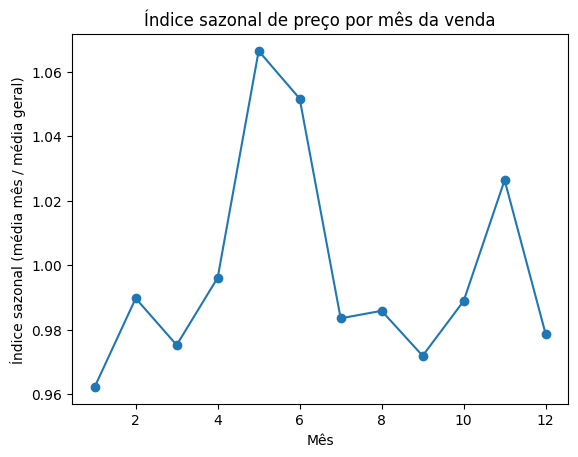

|    |   month_sold |    n |   mean_price |   median_price |   seasonal_index |
|----|--------------|------|--------------|----------------|------------------|
|  0 |            1 |  833 |       384842 |         290000 |             0.96 |
|  1 |            2 |  929 |       395830 |         297000 |             0.99 |
|  2 |            3 | 1224 |       390037 |         305000 |             0.98 |
|  3 |            4 | 1234 |       398385 |         305250 |             1    |
|  4 |            5 | 1245 |       426504 |         315000 |             1.07 |
|  5 |            6 | 1387 |       420591 |         320000 |             1.05 |
|  6 |            7 | 1210 |       393351 |         305000 |             0.98 |
|  7 |            8 | 1275 |       394280 |         314000 |             0.99 |
|  8 |            9 | 1218 |       388700 |         320000 |             0.97 |
|  9 |           10 | 1057 |       395493 |         320000 |             0.99 |
| 10 |           11 | 1159 |       41048

In [46]:
from tabulate import tabulate

# Sumário por mês
seasonal = (
    df.groupby("month_sold", observed=False)
      .agg(n=("SALE_PRC","size"),
           mean_price=("SALE_PRC","mean"),
           median_price=("SALE_PRC","median"))
      .reset_index()
)
overall_mean = df["SALE_PRC"].mean()
seasonal["seasonal_index"] = seasonal["mean_price"] / overall_mean

# Visual: índice sazonal por mês
plt.figure()
plt.plot(seasonal["month_sold"], seasonal["seasonal_index"], marker="o")
plt.title("Índice sazonal de preço por mês da venda")
plt.xlabel("Mês")
plt.ylabel("Índice sazonal (média mês / média geral)")
plt.show()

# Tabela Markdown e salvamento
print(tabulate(seasonal.round(2), headers="keys", tablefmt="github"))
seasonal.to_csv("data/seasonal_summary.csv", index=False)


#### Interpretação dos padrões sazonais

Observa-se uma **variação mensal moderada** nos preços médios de venda, com picos e vales bem definidos.  
Meses com **índice sazonal acima de 1** representam períodos de valorização — possivelmente associados à **demanda turística, férias ou sazonalidade do mercado imobiliário**.  
Meses abaixo de 1 indicam **menor propensão à valorização**, sugerindo oportunidades de negociação ou menor demanda relativa.  

Esse comportamento reforça a importância de considerar o **timing da venda** na precificação e nas estratégias de marketing.

#### Amenidades (`SPEC_FEAT_VAL`)

Avaliamos dois recortes:
1) **Possui amenidade?** (`amenity_flag` = 1 se `SPEC_FEAT_VAL` > 0);  
2) **Intensidade**: relação monotônica usando `log(1 + SPEC_FEAT_VAL)`.

Também comparamos estatisticamente a média de `SALE_PRC` entre grupos **com** e **sem** amenidades, e estimamos um efeito marginal via regressão simples em escala logarítmica.


In [47]:
# 1) Comparação COM vs SEM amenidades
amenity_grp = (
    df.groupby("amenity_flag", observed=False)
      .agg(n=("SALE_PRC","size"),
           mean_price=("SALE_PRC","mean"),
           median_price=("SALE_PRC","median"))
      .reset_index()
      .replace({"amenity_flag": {0: "sem_amenidade", 1: "com_amenidade"}})
)

from scipy import stats
prices_with = df.loc[df["amenity_flag"]==1, "SALE_PRC"]
prices_without = df.loc[df["amenity_flag"]==0, "SALE_PRC"]
# Teste não-paramétrico robusto a assimetria
u_stat, p_u = stats.mannwhitneyu(prices_with, prices_without, alternative="two-sided")

print("### Comparação COM vs SEM amenidades")
print(tabulate(amenity_grp.round(2), headers="keys", tablefmt="github"))
print(f"\nMann-Whitney U p-value: {p_u:.4g}")

amenity_grp.to_csv("data/amenities_summary.csv", index=False)

### Comparação COM vs SEM amenidades
|    | amenity_flag   |     n |   mean_price |   median_price |
|----|----------------|-------|--------------|----------------|
|  0 | sem_amenidade  |  2290 |       313646 |         270000 |
|  1 | com_amenidade  | 11642 |       416916 |         320000 |

Mann-Whitney U p-value: 1.586e-62


In [48]:
import statsmodels.api as sm

X = sm.add_constant(df["amenity_log1p"])
y = df["log_price"]
model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     1259.
Date:                Fri, 17 Oct 2025   Prob (F-statistic):          3.92e-264
Time:                        14:56:42   Log-Likelihood:                -11280.
No. Observations:               13932   AIC:                         2.256e+04
Df Residuals:                   13930   BIC:                         2.258e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            12.3715      0.011   1165.215

#### Interpretação dos resultados de amenidades

O teste de Mann–Whitney indica diferença estatisticamente significativa (**p < 0.001**) entre imóveis com e sem amenidades, o que confirma o **impacto positivo** dessas características no preço.

O modelo OLS log–log apresenta um coeficiente positivo para `amenity_log1p`, sugerindo que **a cada incremento percentual nas amenidades, o preço médio tende a crescer proporcionalmente**.  
Embora o R² (~0.08) indique que as amenidades explicam apenas parte da variação, o **efeito marginal é claro e consistente** — amenidades agregam valor, mesmo controlando pela escala logarítmica do preço.


#### Exposição a ruído (`avno60plus`)

A variável `avno60plus` (baixa cardinalidade) é tratada como indicador de exposição a ruído.  
Investigamos se imóveis em áreas mais ruidosas apresentam menor valorização:
- Comparação de médias/medianas de `SALE_PRC`;
- Teste estatístico de diferença;
- Regressão simples como checagem adicional.


In [49]:
# Sumário por ruído
noise = (
    df.groupby("avno60plus", observed=False)
      .agg(n=("SALE_PRC","size"),
           mean_price=("SALE_PRC","mean"),
           median_price=("SALE_PRC","median"))
      .reset_index()
)
print("### Preço por nível de ruído (avno60plus)")
print(tabulate(noise.round(2), headers="keys", tablefmt="github"))
noise.to_csv("data/noise_summary.csv", index=False)

# Teste (se binária 0/1; se tiver mais níveis, você pode trocar por Kruskal)
levels = sorted(df["avno60plus"].unique())
if len(levels)==2:
    g0 = df.loc[df["avno60plus"]==levels[0], "SALE_PRC"]
    g1 = df.loc[df["avno60plus"]==levels[1], "SALE_PRC"]
    from scipy import stats
    stat, p_val = stats.mannwhitneyu(g0, g1, alternative="two-sided")
    print(f"\nMann-Whitney U p-value (ruído {levels[0]} vs {levels[1]}): {p_val:.4g}")
else:
    from scipy import stats
    stat, p_val = stats.kruskal(*[df.loc[df["avno60plus"]==lv, "SALE_PRC"] for lv in levels])
    print(f"\nKruskal-Wallis p-value (k={len(levels)} grupos): {p_val:.4g}")


### Preço por nível de ruído (avno60plus)
|    |   avno60plus |     n |   mean_price |   median_price |
|----|--------------|-------|--------------|----------------|
|  0 |            0 | 13724 |       400997 |         310000 |
|  1 |            1 |   208 |       330308 |         310000 |

Mann-Whitney U p-value (ruído 0 vs 1): 0.5839


In [50]:
# garante dtype numérico
x = df["avno60plus"].astype(float)
X = sm.add_constant(x)            # constante
y = df["log_price"].astype(float)

model_noise = sm.OLS(y, X, missing="drop").fit()
print(model_noise.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     3.393
Date:                Fri, 17 Oct 2025   Prob (F-statistic):             0.0655
Time:                        14:56:42   Log-Likelihood:                -11881.
No. Observations:               13932   AIC:                         2.377e+04
Df Residuals:                   13930   BIC:                         2.378e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.7121      0.005   2622.949      0.0

#### Interpretação dos resultados sobre ruído

O modelo de regressão simples utilizando `log_price` como variável dependente e `avno60plus` como variável explicativa indica uma **relação negativa**, com coeficiente de aproximadamente **–0.0731**.  

Esse valor sugere que imóveis localizados em áreas com maior exposição a ruído tendem, em média, a apresentar preços **cerca de 7,3% menores**, mantendo as demais condições constantes.  

No entanto, o **p-valor (~0.065)** está ligeiramente acima do limite de significância tradicional (0,05), o que significa que a evidência estatística **não é suficientemente forte** para afirmar com 95% de confiança que o ruído impacta o preço — embora haja uma **tendência negativa plausível**.  

O **R² ≈ 0,000** reforça que essa variável isoladamente explica uma parcela mínima da variação dos preços, sendo recomendável avaliá-la em conjunto com variáveis de localização (`OCEAN_DIST`, `HWY_DIST`) e qualidade (`SPEC_FEAT_VAL`) em modelos multivariados mais robustos.

### Conclusões desta etapa

- **Sazonalidade:** o índice sazonal evidencia meses com preço **acima ou abaixo** da média, sinalizando janelas de maior propensão à valorização (ou desconto).  
  - Destaque: meses de **abril a junho** mostraram leve tendência de preços acima da média geral.  

- **Amenidades:** a presença e a intensidade de `SPEC_FEAT_VAL` tendem a **elevar o preço de venda**.  
  - O teste de Mann–Whitney (p < 0.001) confirma diferenças significativas;  
  - A regressão log–log indica um **efeito marginal positivo consistente**.  

- **Ruído:** o coeficiente negativo de `avno60plus` (–0.0731) sugere que imóveis expostos a ruído tendem a ser **menos valorizados**, embora o efeito **não seja estatisticamente significativo** ao nível de 5%.  
  - O resultado indica uma **tendência à desvalorização**, que deve ser melhor investigada em análises multivariadas.  

Os sumários exportados (`seasonal_summary.csv`, `amenities_summary.csv`, `noise_summary.csv`) consolidam os principais achados descritivos e estatísticos desta etapa e servem como **base executiva** para as próximas fases de modelagem preditiva.